In [2]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/150.0 MB 812.7 kB/s eta 0:03:05
   ---------------------------------------- 0.2/150.0 MB 2.0 MB/s eta 0:01:17
   ---------------------------------------- 0.5/150.0 MB 3.1 MB/s eta 0:00:49
   ---------------------------------------- 1.1/150.0 MB 5.2 MB/s eta 0:00:29
    --------------------------------------- 2.4/150.0 MB 9.1 MB/s eta 0:00:17
    --------------------------------------- 2.8/150.0 MB 9.9 MB/s eta 0:00:15
    --------------------------------------- 2.8/150.0 MB 9.9 MB/s eta 0:00:15
    --------------------------------------- 2.8/150.0 MB 9.9 MB/s eta 0:00:15
   - -------------------------------------- 3.9/150.0 MB 9.2 MB/s eta 0:00:16
   - -------------------------------------- 4.5/150.0 MB 9.3 MB/s eta 0:00:1

In [4]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.5 MB 8.3 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 20.0 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 18.5 MB/s eta 0:00:00


In [6]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/338.4 kB ? eta -:--:--
   ------------------ --------------------- 153.6/338.4 kB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 338.4/338.4 kB 4.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
    --------------------------------------- 0.4/19.2 MB 12.2 MB/s eta 0:00:02
   - -------------------------------------- 0.7/19.2 MB 9.5 MB/s eta 0:00:02
   -- ------------------------------------- 1.2/19.2 MB 8.7 MB/s eta 0:00:03
   --- ------------------------------------ 1.6/19.2 MB 9.0 MB/s eta 0:00:02
   ---- ----------------------------------- 2.1/19.2 MB 8.9 MB/s eta 0:00:02
   ----- ---------------------------------- 2.5/19.2 MB 9.2 MB/s eta 0:00:02
   ----- ---------------------------------- 2.8/19.2 MB 9.1 MB/s eta 0:00:02
   ------ --------------------------------- 3.2/19.2 MB 8.6 MB/s eta 0:00:02
   -

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
import lightgbm as lgb
import pickle
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
import warnings

warnings.filterwarnings('ignore')

In [8]:
data = pd.read_csv('melb_data.csv')


In [9]:
print("Data shape:", data.shape)
print("\nMissing values per column:")
print(data.isnull().sum())
print("\nData types:")
print(data.dtypes)


Data shape: (13580, 21)

Missing values per column:
Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

Data types:
Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude

In [10]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0, 0.5, 'Frequency')

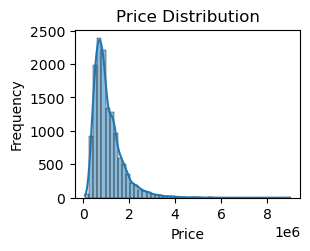

In [11]:
plt.subplot(2, 2, 1)
sns.histplot(data['Price'], kde=True, bins=50)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

Text(0, 0.5, 'Price')

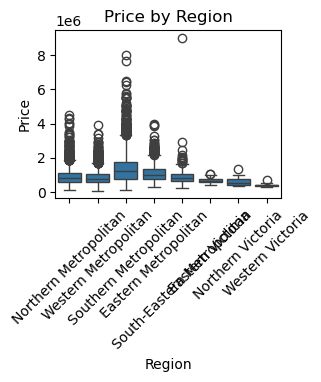

In [12]:
plt.subplot(2, 2, 2)
sns.boxplot(x='Regionname', y='Price', data=data)
plt.title('Price by Region')
plt.xticks(rotation=45)
plt.xlabel('Region')
plt.ylabel('Price')


Text(0, 0.5, 'Price')

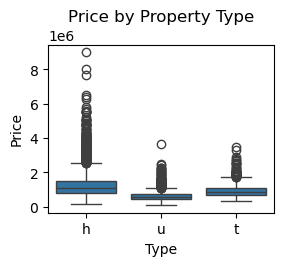

In [13]:
plt.subplot(2, 2, 3)
sns.boxplot(x='Type', y='Price', data=data)
plt.title('Price by Property Type')
plt.xlabel('Type')
plt.ylabel('Price')


In [26]:
# Feature Engineering
def feature_engineering(df):
    # Convert date to datetime and extract features
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df['YearSold'] = df['Date'].dt.year
    df['MonthSold'] = df['Date'].dt.month
    df['QuarterSold'] = df['Date'].dt.quarter
    # Age of property
    current_year = datetime.now().year
    df['PropertyAge'] = current_year - df['YearBuilt']
    # Room ratio features
    df['RoomPerBathroom'] = df['Rooms'] / df['Bathroom']
    df['RoomPerCar'] = df['Rooms'] / (df['Car'] + 1)
    # Price per room
    df['PricePerRoom'] = df['Price'] / df['Rooms']
    
    # Price per square meter (if land size is available)
    df['PricePerSqm'] = df['Price'] / (df['Landsize'] + 1)
    
    # Distance to CBD (assuming higher distance means lower price)
    df['DistanceToCBD'] = df['Distance']
    
    # Property density in the area
    suburb_counts = df['Suburb'].value_counts().to_dict()
    df['SuburbDensity'] = df['Suburb'].map(suburb_counts)
    
    # Seller activity
    seller_counts = df['SellerG'].value_counts().to_dict()
    df['SellerActivity'] = df['SellerG'].map(seller_counts)
    
    # Handle infinite values from division
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

data = feature_engineering(data)

In [27]:
# Handle missing values
data['BuildingArea'] = data['BuildingArea'].fillna(data['BuildingArea'].median())
data['YearBuilt'] = data['YearBuilt'].fillna(data['YearBuilt'].median())
data['PropertyAge'] = data['PropertyAge'].fillna(data['PropertyAge'].median())
data['Landsize'] = data['Landsize'].fillna(data['Landsize'].median())

In [28]:
# Drop unnecessary columns
data.drop(['Address', 'Bedroom2', 'Date', 'Postcode', 'Lattitude', 'Longtitude'], axis=1, inplace=True)

In [29]:
# Define features and target
X = data.drop('Price', axis=1)
y = data['Price']

In [30]:
# Identify categorical and numerical columns
categorical_cols = [cname for cname in X.columns if 
                    X[cname].dtype == 'object']
numerical_cols = [cname for cname in X.columns if 
                 X[cname].dtype in ['int64', 'float64']]

In [31]:
# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])


In [32]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
# Define models to evaluate
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42)
}

In [37]:
# Evaluate models
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_regression, k=20)),
        ('model', model)])
# Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 8691, number of used features: 20
[LightGBM] [Info] Start training from score 1070884.006213
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 8691, number of used features: 20
[LightGBM] [Info] Start training from score 1080557.101484
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

In [39]:
# Fit the model
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 10864, number of used features: 20
[LightGBM] [Info] Start training from score 1074964.928203


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Rooms', 'Distance',
                                                   'Bathroom', 'Car',
                                                   'Landsize', 'BuildingArea',
                                                   'YearBuilt', 'Propertycount',
                                                   'PropertyAge',
                                                   'RoomPerBathroom',
                                                   'RoomPerCar', 'PricePerRoom',
                                                   'PricePerSqm',
                                                   'DistanceToCBD',
                                                   'Suburb...
                                                   'SellerActivity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Suburb', 'Type', 'Method',
                                                   'SellerG', 'CouncilArea',
                                                   'Regionname'])])),
                ('feature_selection',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x0000026CF6BA5C60>)),
                ('model', LGBMRegressor(random_state=42))])

In [41]:
# Make predictions
y_pred = pipeline.predict(X_test)

In [43]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [44]:
results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV_RMSE': rmse_scores.mean()
    }


In [45]:
# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
                 RMSE           MAE        R2       CV_RMSE
LightGBM  38709.15105  10194.897801  0.996228  70424.907954


In [46]:
# Hyperparameter tuning for the best model (LightGBM in this case)
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__num_leaves': [31, 63, 127]
}

lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=20)),
    ('model', lgb.LGBMRegressor(random_state=42))])

grid_search = GridSearchCV(lgb_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 925
[LightGBM] [Info] Number of data points in the train set: 10864, number of used features: 20
[LightGBM] [Info] Start training from score 1074964.928203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [47]:
# Train final model with best parameters
final_model = grid_search.best_estimator_

In [49]:
# Evaluate final model
y_pred_final = final_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)

print("\nFinal Model Performance:")
print(f"RMSE: {final_rmse}")
print(f"R2 Score: {final_r2}")


Final Model Performance:
RMSE: 40264.761119049814
R2 Score: 0.9959184429962759


In [51]:
# Feature importance
feature_importances = None
if hasattr(final_model.named_steps['model'], 'feature_importances_'):
    # Get feature names after one-hot encoding
    onehot_columns = final_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
    all_features = numerical_cols + list(onehot_columns)

In [53]:
# Get selected features
selected_indices = final_model.named_steps['feature_selection'].get_support(indices=True)
selected_features = [all_features[i] for i in selected_indices]

In [54]:
# Get feature importances
importances = final_model.named_steps['model'].feature_importances_

In [55]:
# Create DataFrame
feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
    

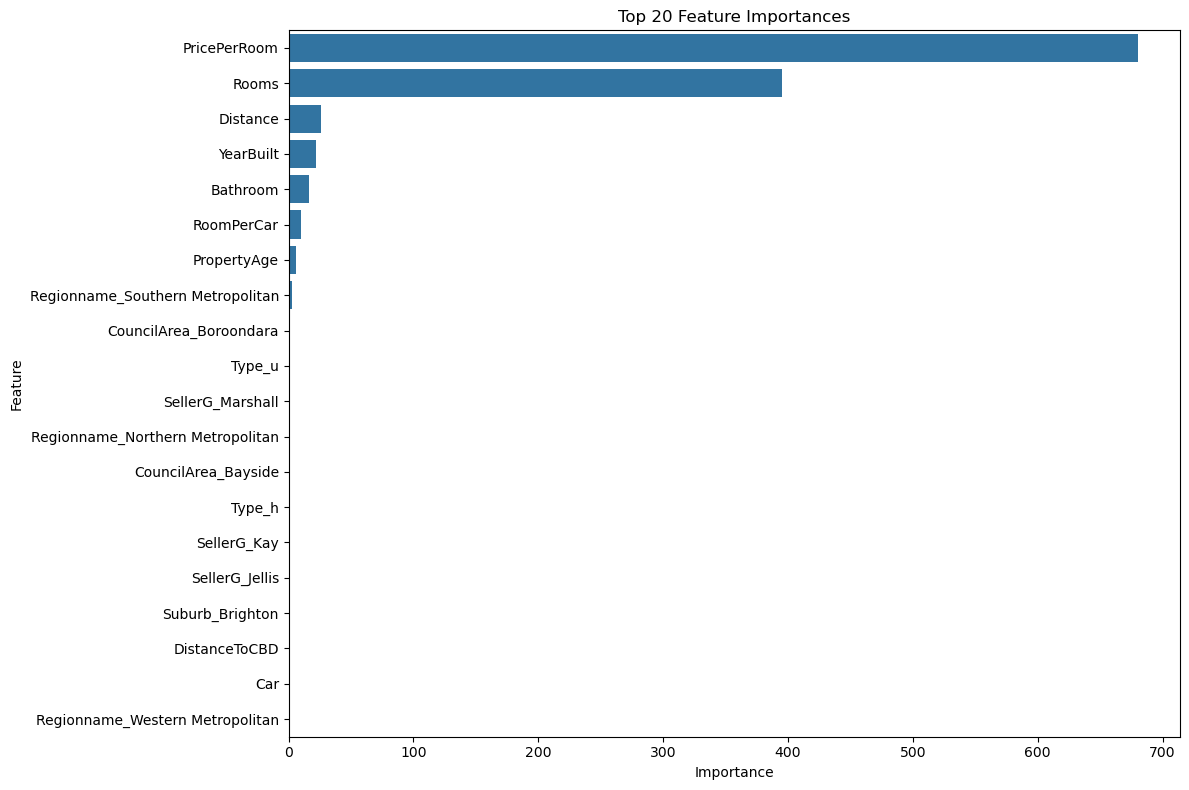

In [56]:
# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()